Let the fun begin 🚀

In [1]:
# # # !pip install numpy pandas obspy matplotlib
# !pip install obspy

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy.signal import spectrogram as scipy_spectrogram
from collections import OrderedDict


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir  = '/content/drive/MyDrive/NASA_SpaceApps/space_apps_2024_seismic_detection'

In [5]:
data_dir = f'{root_dir}/data/lunar'

In [6]:
cat_directory = f'{data_dir}/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [7]:
def load_seismic_data(mseed_directory, catalog):
    """
    Loads seismic signals from .mseed files and creates a dictionary mapping file names to signals.
    Also loads the P-wave start times from the catalog file and associates them with the signals.

    :param mseed_directory: Directory containing the .mseed files.
    :param catalog_file: CSV file containing catalog with P-wave start times.
    :return: A dictionary mapping filename to (signal, p_wave_start_time).
    """
    # Load the catalog CSV


    # Dictionary to hold file name : (signal, p_wave_start_time) mapping
    signal_mapping = OrderedDict()

    # Iterate through the rows in the catalog to match filenames and start times
    for index, row in catalog.iterrows():
        filename = row['filename'] + '.mseed'  # Assuming 'filename' is a column in your CSV
        p_wave_start_time = row['time_rel(sec)']  # Assuming 'p_wave_start_time' is in seconds

        # Full path to the .mseed file
        filepath = os.path.join(mseed_directory, filename)
        #print(filepath)
        if os.path.exists(filepath):
            # Load the .mseed file using obspy
            st = read(filepath)
            signal = st.traces[0].data  # Assuming we're only interested in the first trace

            # Store the signal and the associated P-wave start time in the dictionary
            signal_mapping[filename] = (signal, p_wave_start_time, st.traces[0].stats.sampling_rate)
        else:
            print(f"File {filename} not found in directory.")

    return signal_mapping

In [8]:
def generate_gaussian_noise(signal, snr_db):
    """
    Adds White Gaussian Noise (WGN) to the signal based on the specified signal-to-noise ratio.
    :param signal: Original seismic signal.
    :param snr_db: Desired signal-to-noise ratio in decibels.
    :return: Noisy signal.
    """
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

# Step 3: Generate Spectrogram using scipy.signal.spectrogram
def generate_spectrogram(signal, sampling_rate, fs=200, window_size=64, overlap=32):
    """
    Generates the spectrogram using scipy's built-in method.
    :param signal: Noisy seismic signal.
    :param fs: Sampling frequency.
    :param window_size: Spectrogram window size.
    :param overlap: Spectrogram overlap.
    :return: Spectrogram, time axis, frequency axis.
    """
    f, t, Sxx = scipy_spectrogram(signal, sampling_rate, nperseg=window_size, noverlap=overlap)
    #spectrogram = np.abs(Sxx)
    return Sxx, t, f

# Step 4: Generate 2D Segmentation Label
def generate_2d_label(p_wave_start_time, spectrogram_shape, t, fs=200):
    """
    Generate a 2D label matrix marking the P-wave start time.
    :param p_wave_start_time: The P-wave start time in seconds.
    :param spectrogram_shape: Shape of the spectrogram (F, T).
    :param t: Time axis from the spectrogram.
    :param fs: Sampling frequency.
    :return: 2D binary label matrix.
    """
    F, T = spectrogram_shape
    labels = np.zeros((F, T))

    # Find the time index closest to the P-wave start time
    event_start_idx = np.argmin(np.abs(t - p_wave_start_time))

    # Mark the event start time across all frequency bins
    labels[:, event_start_idx] = 1
    return labels

# Step 5: Create Dataset of Spectrograms and Labels
def create_dataset(mseed_directory, catalog_file, fs=200, snr_db=-5):
    """
    Creates a dataset of spectrograms and their corresponding labels.
    :param mseed_directory: Directory containing the .mseed files.
    :param catalog_file: CSV file containing the P-wave start times.
    :param fs: Sampling frequency.
    :param snr_db: Desired signal-to-noise ratio for adding Gaussian noise.
    :return: Two datasets - one with spectrograms and labels, and another with spectrogram, label, and filename.
    """
    # Load seismic signals and associated start times
    signal_mapping = load_seismic_data(mseed_directory, catalog_file)

    dataset_full = []
    dataset_spectrogram_label = []

    # Iterate through the signals
    for filename, (signal, p_wave_start_time, sampling_rate) in signal_mapping.items():
        # Apply Gaussian noise to the signal
        noisy_signal = generate_gaussian_noise(signal, snr_db=snr_db)

        # Generate spectrogram
        spectrogram, time_axis, freq_axis = generate_spectrogram(noisy_signal, sampling_rate, fs=fs)

        # Generate label
        label = generate_2d_label(p_wave_start_time, spectrogram.shape, time_axis)

        # Add to full dataset (spectrogram, label, filename)
        dataset_full.append((spectrogram, label, filename, time_axis))

        # Add to subset dataset (only spectrogram and label)
        dataset_spectrogram_label.append((spectrogram, label))

    return dataset_full, dataset_spectrogram_label


In [9]:
def normalize_spectrogram(spectrogram):
    """
    Normalizes the spectrogram between 0 and 1.
    :param spectrogram: 2D array of spectrogram values.
    :return: Normalized spectrogram.
    """
    spectrogram_min = np.min(spectrogram)
    spectrogram_max = np.max(spectrogram)
    normalized_spectrogram = (spectrogram - spectrogram_min) / (spectrogram_max - spectrogram_min)
    return normalized_spectrogram


In [10]:
def plot_label(label, p_wave_start_time, t, fs=200):
    """
    Plots the 2D label with an indicator for the P-wave start.
    :param label: 2D label matrix.
    :param p_wave_start_time: P-wave start time (for verification).
    :param t: Time axis of the spectrogram.
    :param fs: Sampling frequency.
    """
    plt.figure(figsize=(14, 6))  # Increase the figure size
    plt.imshow(label, aspect='auto', cmap='hot', origin='lower')  # Use a color map that enhances contrast
    plt.title(f"2D Label (P-wave Start at {p_wave_start_time:.5f}s)")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(label="Label (0 or 1)")

    # Plot a vertical line at the time index where the P-wave starts
    p_wave_idx = np.argmin(np.abs(t - p_wave_start_time))
    plt.axvline(x=p_wave_idx, color='r', linestyle='--', label='P-wave Start')
    plt.legend()
    plt.show()


In [11]:
def reverse_map_to_time(predicted_label, t, fs=200):
    """
    Reverse maps the predicted label's P-wave start column back to the absolute time.
    :param predicted_label: 2D predicted label matrix.
    :param t: Time axis of the spectrogram.
    :param fs: Sampling frequency.
    :return: Estimated P-wave start time.
    """
    # Find the index of the column where the P-wave start is predicted
    p_wave_start_idx = np.argmax(np.sum(predicted_label, axis=0))

    # Get the corresponding time from the time axis
    estimated_p_wave_start_time = t[p_wave_start_idx]
    return estimated_p_wave_start_time


In [12]:
mseed_directory = f'{data_dir}/training/data/S12_GradeA'

In [13]:
dataset_full, dataset_spectrogram_label = create_dataset(mseed_directory, cat, fs=200, snr_db=-5)

# Example to visualize the first spectrogram and label pair
spectrogram, label, filename, time_axis = dataset_full[0]

File xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed not found in directory.


In [14]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, test_size=0.2, val_size=0.1):
    """
    Splits the dataset into training, validation, and test sets.
    :param dataset: List of tuples (spectrogram, label, filename, time_axis).
    :param test_size: Proportion of the dataset to be used as test data.
    :param val_size: Proportion of the remaining dataset to be used as validation data.
    :return: Train, validation, and test datasets.
    """
    # First split into training+validation and test sets
    train_val, test = train_test_split(dataset, test_size=test_size, random_state=42)

    # Now split the training+validation set into training and validation
    train_size = 1 - val_size
    train, val = train_test_split(train_val, test_size=val_size, random_state=42)

    return train, val, test


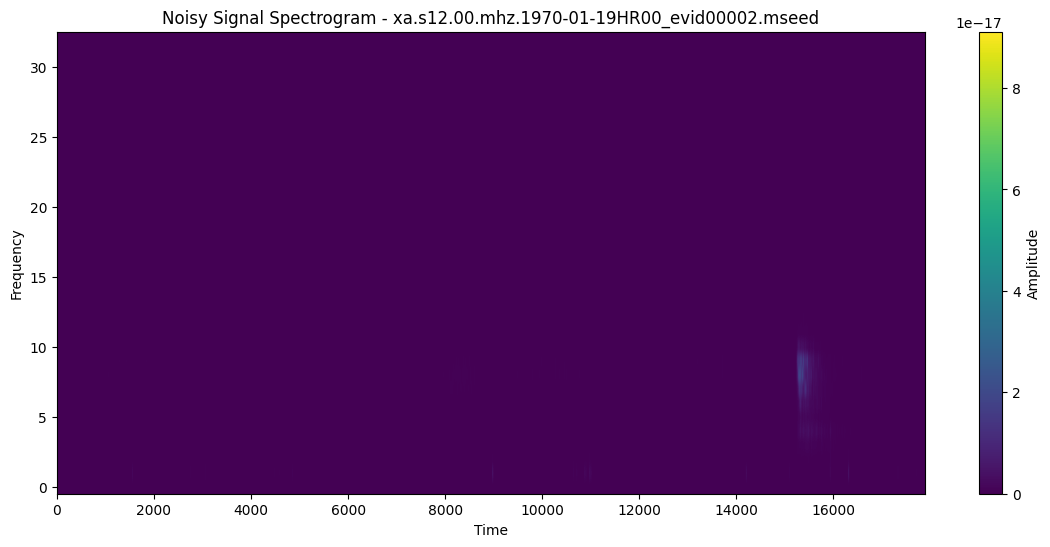

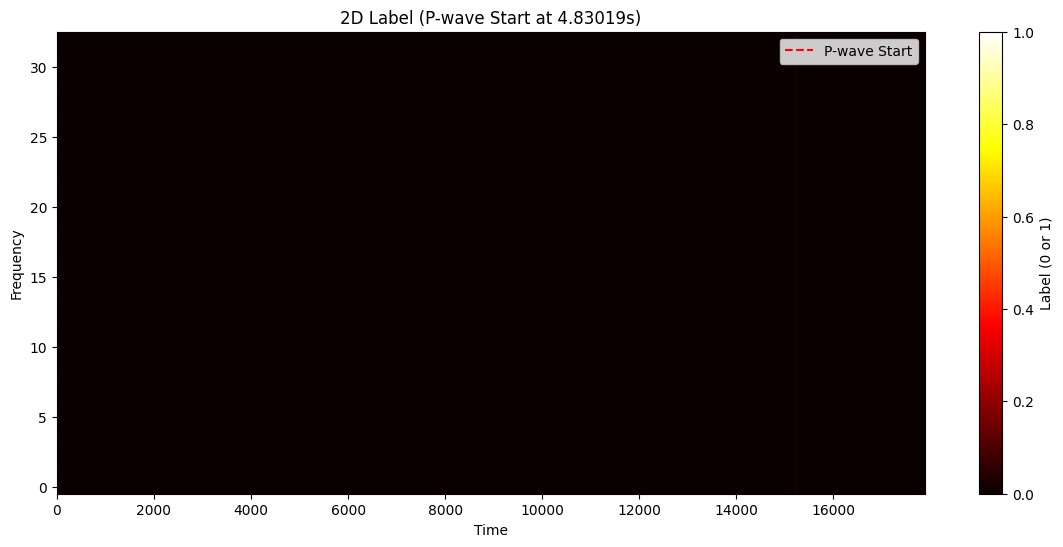

Estimated P-wave Start Time: 73500.98113 seconds


In [70]:
# Step 1: Split the dataset
train_set, val_set, test_set = split_dataset(dataset_full, test_size=0.1, val_size=0.1)

# Step 2: Visualize the first entry in the training set
spectrogram, label, filename, time_axis = dataset_full[0]

# Plot the spectrogram
plt.figure(figsize=(14, 6))
plt.imshow(spectrogram, aspect='auto', cmap='viridis', origin='lower')
plt.title(f"Noisy Signal Spectrogram - {filename}")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Amplitude")
plt.show()

# Plot the enhanced label visualization
plot_label(label, time_axis[0], time_axis)

# Step 3: Reverse map the label to estimate the P-wave start time
estimated_p_wave_start_time = reverse_map_to_time(label, time_axis)
print(f"Estimated P-wave Start Time: {estimated_p_wave_start_time:.5f} seconds")


In [16]:
filename

'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'

In [17]:
cat[cat['filename']=='xa.s12.00.mhz.1971-02-09HR00_evid00026']

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
18,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T03:42:00.000000,13320.0,evid00026,impact_mq


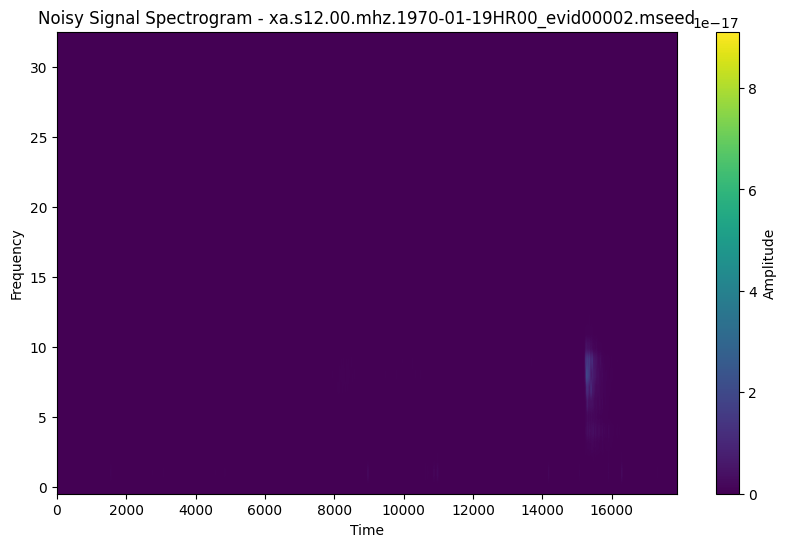

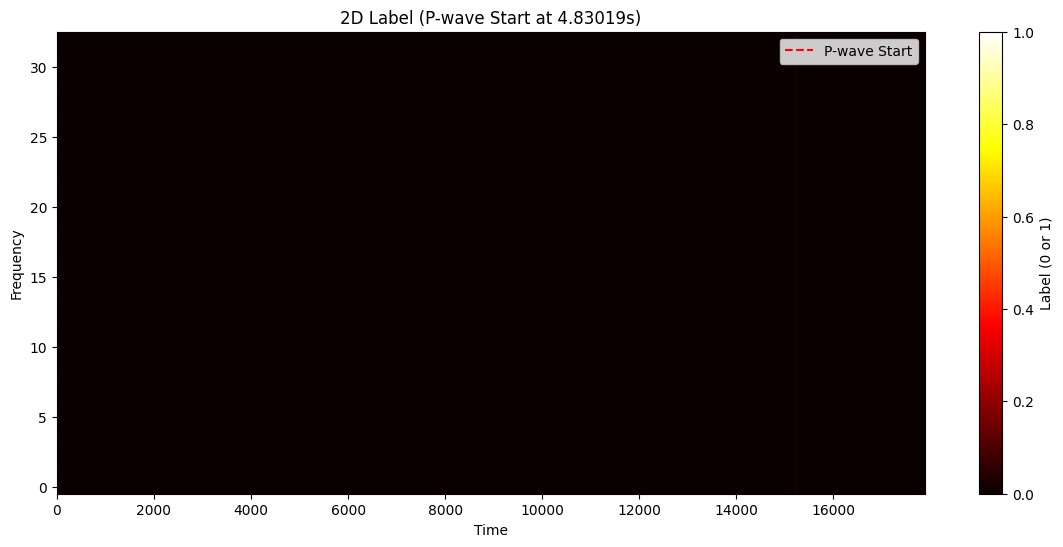

In [18]:
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram, aspect='auto', cmap='viridis', origin='lower')
plt.title(f"Noisy Signal Spectrogram - {filename}")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Amplitude")
plt.show()

# Plot the label with a time index marker
plot_label(label, time_axis[0], time_axis)

In [19]:
reverse_map_to_time(label, time_axis)

73500.98113207547

In [20]:
import torch.nn.functional as F


def pad_spectrogram(spectrogram, target_length):
    """
    Pads the spectrogram to the target length (in time dimension).
    :param spectrogram: 2D tensor of shape (F, T)
    :param target_length: Desired length for the time dimension.
    :return: Padded spectrogram of shape (F, target_length)
    """
    F_dim, T_dim = spectrogram.shape
    if T_dim < target_length:
        padding = target_length - T_dim
        # Padding only on the right side (time dimension)
        spectrogram = F.pad(spectrogram, (0, padding), "constant", 0)
    return spectrogram


In [71]:
import torch
from torch.utils.data import Dataset, DataLoader

class SeismicDataset(Dataset):
    def __init__(self, data, normalize=True):
        """
        Initializes the dataset with spectrograms, labels, and metadata (time_axis, filename).
        :param data: List of tuples (spectrogram, label, filename, time_axis).
        :param normalize: If True, normalize the spectrogram values.
        """
        self.data = data
        self.normalize = normalize
        self.target_time_length = 17887

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label, filename, time_axis = self.data[idx]

        # Normalize the spectrogram
        if self.normalize:
            spectrogram = normalize_spectrogram(spectrogram)

        # Convert spectrogram and label to tensors
        spectrogram = pad_spectrogram(torch.tensor(spectrogram, dtype=torch.float32), self.target_time_length).unsqueeze(0)
        label = pad_spectrogram(torch.tensor(label, dtype=torch.float32), self.target_time_length).unsqueeze(0)

        return spectrogram, label

    def get_metadata(self, idx):
        """
        Retrieve the time axis and filename for a given index.
        :param idx: Index of the data point.
        :return: (filename, time_axis)
        """
        _, _, filename, time_axis = self.data[idx]
        return filename, time_axis

# Example usage:
train_dataset = SeismicDataset(train_set)  # `train_set` is the list of (spectrogram, label, filename, time_axis) tuples
val_dataset = SeismicDataset(val_set)
test_dataset = SeismicDataset(test_set)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()

#         # Encoder
#         self.enc1 = self.conv_block(1, 64)
#         self.enc2 = self.conv_block(64, 128)
#         self.enc3 = self.conv_block(128, 256)
#         self.enc4 = self.conv_block(256, 512)
#         self.enc5 = self.conv_block(512, 1024)

#         # Decoder
#         self.dec4 = self.up_conv(1536, 512)  # Adjusted from 1024 to 1536
#         self.dec3 = self.up_conv(768, 256)   # Adjusted from 512 to 768
#         self.dec2 = self.up_conv(384, 128)   # Adjusted from 256 to 384
#         self.dec1 = self.up_conv(192, 64)    # Adjusted from 128 to 192

#         self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def up_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             self.conv_block(out_channels, out_channels)
#         )

#     def forward(self, x):
#         # Encoding path
#         e1 = self.enc1(x)
#         #print(f"e1 shape: {e1.shape}")
#         e2 = self.enc2(F.max_pool2d(e1, 2))
#         #print(f"e2 shape: {e2.shape}")
#         e3 = self.enc3(F.max_pool2d(e2, 2))
#         #print(f"e3 shape: {e3.shape}")
#         e4 = self.enc4(F.max_pool2d(e3, 2))
#         #print(f"e4 shape: {e4.shape}")
#         e5 = self.enc5(F.max_pool2d(e4, 2))
#         #print(f"e5 shape: {e5.shape}")

#         # Decoding path
#         d4 = self.pad_and_concat(F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=True), e4)
#         #print(f"d4 after concat shape: {d4.shape}")
#         d4 = self.dec4(d4)
#         #print(f"d4 after dec4 shape: {d4.shape}")

#         d3 = self.pad_and_concat(F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True), e3)
#         #print(f"d3 after concat shape: {d3.shape}")
#         d3 = self.dec3(d3)
#         #print(f"d3 after dec3 shape: {d3.shape}")

#         d2 = self.pad_and_concat(F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True), e2)
#         #print(f"d2 after concat shape: {d2.shape}")
#         d2 = self.dec2(d2)
#         #print(f"d2 after dec2 shape: {d2.shape}")

#         d1 = self.pad_and_concat(F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True), e1)
#         #print(f"d1 after concat shape: {d1.shape}")
#         d1 = self.dec1(d1)
#         #print(f"d1 after dec1 shape: {d1.shape}")

#         # Final output
#         return self.final_conv(d1)

#     def pad_and_concat(self, upsampled, bypass):
#         """
#         Pads the bypass (encoder) feature map to match the size of the upsampled (decoder) feature map.
#         Then concatenates them along the channel axis.
#         """
#         _, _, H, W = upsampled.size()
#         bypass = self.pad_to_match(bypass, H, W)
#         return torch.cat((upsampled, bypass), dim=1)

#     def pad_to_match(self, layer, target_height, target_width):
#         """
#         Pads the input layer (bypass) to the target height and width.
#         """
#         _, _, H, W = layer.size()
#         diff_y = target_height - H
#         diff_x = target_width - W
#         pad_top = diff_y // 2
#         pad_bottom = diff_y - pad_top
#         pad_left = diff_x // 2
#         pad_right = diff_x - pad_left
#         return F.pad(layer, (pad_left, pad_right, pad_top, pad_bottom), "constant", 0)


In [67]:
import torch.nn.functional as F

class SimplifiedUNet(nn.Module):
    def __init__(self):
        super(SimplifiedUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Decoder
        self.dec3 = self.up_conv(384, 128)
        self.dec2 = self.up_conv(192, 64)
        self.dec1 = self.up_conv(96, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            self.conv_block(in_channels, out_channels)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Decoding path
        d3 = self.pad_and_concat(F.interpolate(e4, scale_factor=2, mode='bilinear', align_corners=True), e3)
        d3 = self.dec3(d3)

        d2 = self.pad_and_concat(F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True), e2)
        d2 = self.dec2(d2)

        d1 = self.pad_and_concat(F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True), e1)
        d1 = self.dec1(d1)

        # Final output
        out = self.final_conv(d1)

        # Pad the output to match the label size
        out = F.pad(out, (0, 7, 0, 1))  # Adjust based on the size difference between prediction and label
        return out

    def pad_and_concat(self, upsampled, bypass):
        _, _, H, W = upsampled.size()
        bypass = self.pad_to_match(bypass, H, W)
        return torch.cat((upsampled, bypass), dim=1)

    def pad_to_match(self, layer, target_height, target_width):
        _, _, H, W = layer.size()
        diff_y = target_height - H
        diff_x = target_width - W
        pad_top = diff_y // 2
        pad_bottom = diff_y - pad_top
        pad_left = diff_x // 2
        pad_right = diff_x - pad_left
        return F.pad(layer, (pad_left, pad_right, pad_top, pad_bottom), "constant", 0)
# Example instantiation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplifiedUNet().to(device)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()

#         # Encoder
#         self.enc1 = self.conv_block(1, 64)
#         self.enc2 = self.conv_block(64, 128)
#         self.enc3 = self.conv_block(128, 256)
#         self.enc4 = self.conv_block(256, 512)
#         self.enc5 = self.conv_block(512, 1024)

#         # Decoder
#         self.dec4 = self.up_conv(1536, 512)  # Adjusted from 1024 to 1536 to handle concatenation
#         self.dec3 = self.up_conv(768, 256)   # Adjusted from 512 to 768
#         self.dec2 = self.up_conv(384, 128)   # Adjusted from 256 to 384
#         self.dec1 = self.up_conv(192, 64)    # Adjusted from 128 to 192

#         self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

#     def conv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def up_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             self.conv_block(out_channels, out_channels)
#         )

#     def forward(self, x):
#         # Encoding path
#         e1 = self.enc1(x)
#         e2 = self.enc2(F.max_pool2d(e1, 2))
#         e3 = self.enc3(F.max_pool2d(e2, 2))
#         e4 = self.enc4(F.max_pool2d(e3, 2))
#         e5 = self.enc5(F.max_pool2d(e4, 2))

#         # Decoding path
#         d4 = torch.cat([F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=True), e4], dim=1)
#         d4 = self.dec4(d4)

#         d3 = torch.cat([F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True), e3], dim=1)
#         d3 = self.dec3(d3)

#         d2 = torch.cat([F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True), e2], dim=1)
#         d2 = self.dec2(d2)

#         d1 = torch.cat([F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True), e1], dim=1)
#         d1 = self.dec1(d1)

#         # Final output
#         return self.final_conv(d1)


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [74]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
import matplotlib.pyplot as plt
import os

# Set hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 10
patience = 2
min_lr = learning_rate * 0.001
factor = 0.5
checkpoint_dir = f"{root_dir}/checkpoints"

# Make sure the checkpoint directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Initialize model, optimizer, loss function
#model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Callback: ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, min_lr=min_lr)

# Callback: ModelCheckpoint (Save best model based on validation loss)
best_val_loss = float("inf")
checkpoint_file = os.path.join(checkpoint_dir, "unet_best.pth")

def save_model(epoch, val_loss):
    """ Save model checkpoint if validation loss improves """
    global best_val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Model saved with val_loss {val_loss:.5f} at epoch {epoch}")

# Callback: Save metrics for visualization (spectrograms, labels, and reverse mapping)
# Callback: Save metrics for visualization (spectrograms, labels, and reverse mapping)
def save_metrics(spectrogram, actual_label, predicted_label, filename, time_axis, p_wave_time_json):
    # Plot the spectrogram, predicted label, and actual label
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    axes[0].imshow(spectrogram, aspect='auto', cmap='viridis', origin='lower')
    axes[0].set_title('Spectrogram')

    axes[1].imshow(predicted_label, aspect='auto', cmap='gray', origin='lower')
    axes[1].set_title('Predicted Label')

    axes[2].imshow(actual_label, aspect='auto', cmap='gray', origin='lower')
    axes[2].set_title('Actual Label')

    # Save the figure
    plt.tight_layout()
    plt.savefig(f"{root_dir}/results/{filename}_spectrogram_label.png")
    plt.close(fig)

    # Reverse map the time
    predicted_p_wave_time = reverse_map_to_time(predicted_label.squeeze(), time_axis)
    actual_p_wave_time = reverse_map_to_time(actual_label.squeeze(), time_axis)
    time_diff = abs(predicted_p_wave_time - actual_p_wave_time)

    # Store in JSON format
    p_wave_time_json[filename] = {
        "predicted_p_wave_time": predicted_p_wave_time,
        "actual_p_wave_time": actual_p_wave_time,
        "time_difference": time_diff
    }


# Reverse mapping function (already defined above)
def reverse_map_to_time(predicted_label, time_axis):
    """ Reverse map the predicted label to the corresponding time """
    p_wave_start_idx = np.argmax(np.sum(predicted_label, axis=0))
    estimated_p_wave_start_time = time_axis[p_wave_start_idx]
    return estimated_p_wave_start_time

# Training and validation loop
def train_model(train_loader, val_loader, epochs, save_interval=1):
    p_wave_time_json = {}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training loop
        for batch_idx, (spectrograms, labels) in enumerate(train_loader):
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(spectrograms)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (spectrograms, labels) in enumerate(val_loader):
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                predictions = model(spectrograms)
                loss = loss_fn(predictions, labels)
                val_loss += loss.item()

                # Save spectrogram and labels during validation
                if epoch % save_interval == 0:
                    filename, time_axis = val_loader.dataset.get_metadata(batch_idx)
                    save_metrics(spectrograms[0].cpu().numpy().squeeze(),
                                 labels[0].cpu().numpy().squeeze(),
                                 predictions[0].cpu().numpy().squeeze(),
                                 filename, time_axis, p_wave_time_json)

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Check for model improvement and save
        save_model(epoch, val_loss)

        # Step scheduler
        scheduler.step(val_loss)

    # Save the reverse mapping result to JSON
    with open(f"{root_dir}/results/p_wave_time_results.json", "w") as f:
        json.dump(p_wave_time_json, f, indent=4)

# Example: train the model
train_model(train_loader, val_loader, epochs=epochs)


Epoch 1/10, Train Loss: 0.00010, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 0
Epoch 2/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 1
Epoch 3/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 2
Epoch 4/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 3
Epoch 5/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 4
Epoch 6/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 5
Epoch 7/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 6
Epoch 8/10, Train Loss: 0.00006, Val Loss: 0.00006
Epoch 9/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 8
Epoch 10/10, Train Loss: 0.00006, Val Loss: 0.00006
Model saved with val_loss 0.00006 at epoch 9


In [66]:
# Print the shapes of all spectrograms and labels in the dataset
for idx in range(len(train_dataset)):
    spectrogram, label = train_dataset[idx]
    print(f"Sample {idx}: Spectrogram shape = {spectrogram.shape}, Label shape = {label.shape}")


Sample 0: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 1: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 2: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 3: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 4: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 5: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 6: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 7: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 8: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 9: Spectrogram shape = torch.Size([1, 33, 17887]), Label shape = torch.Size([1, 33, 17887])
Sample 10: